In [2]:
%pip install gurobipy
import numpy as np
import gurobipy as gp
import pandas as pd
from sklearn.linear_model import LinearRegression
import copy
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 11.5 MB 5.6 MB/s 


In [3]:
data = pd.read_csv('price_demand_data.csv')
data.shape[0]

99

### 1. Fitting a linear regression model to price and demand dataset

In [4]:
X = data.iloc[:,:-1]
Y = data['demand']
reg = LinearRegression().fit(X,Y)
print(reg.score(X, Y),reg.coef_,reg.intercept_)

0.6214724117783329 [-1367.71252416] 1924.7175435291088


### 2. Generation of demand data based on residuals and p=1, c= 0.5, g =0.75, t = 0.15

In [5]:
p = 1
c = 0.5
g = 0.75
t = 0.15

In [6]:
data['residual'] =data['demand']-(data['price']*reg.coef_+reg.intercept_)
demand_df = pd.DataFrame(copy.deepcopy(data['residual']))
demand_df['price'] = 1
demand_df['demand'] = demand_df['price']*reg.coef_+reg.intercept_+demand_df['residual']
demand_df

,residual,price,demand
0,-205.619393,1,351.385626
1,22.515227,1,579.520247
2,-84.785389,1,472.219630
3,-108.067771,1,448.937249
4,116.743975,1,673.748994
...,...,...,...
94,-58.202391,1,498.802628
95,112.098225,1,669.103245
96,-115.296518,1,441.708501
97,301.349231,1,858.354250


### 3. Optimal quantity deduction
The equations will be:

pD - qc - g(d-q) if d>q

and 

pd - qc -t(q-d) if q>d

In [7]:
nd = demand_df.shape[0]

obj = np.zeros(nd+1)
obj[1:] = 1.0/nd
lb = np.zeros(nd+1)
lb[1:] = -np.inf

A = np.zeros((2*nd, len(obj)))
rhs = np.zeros(2*nd)
dir = np.array(['<']*2*nd)

for i in range(nd):
    A[i, 0] = c-g
    A[i, i+1] = 1
    rhs[i] = demand_df['demand'][i]*(-g)
    
    A[nd+i,0] = c+t
    A[nd+i, i+1] = 1
    rhs[nd+i] = demand_df['demand'][i]*(t)

In [8]:
Mod = gp.Model()
Mod_x = Mod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
Mod_con = Mod.addMConstrs(A, Mod_x, dir, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
Mod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
Mod.setParam('TimeLimit', 200)
Mod.Params.OutputFlag = 0 # tell gurobi to shut up!!
Mod.optimize()

Restricted license - for non-production use only - expires 2023-10-25
Set parameter TimeLimit to value 200


In [9]:
Mod.objVal

-325.5213527193693

In [10]:
Mod_x.x[0]

471.8653795908935

### 4. With price impacting demand, solving QCP

In [11]:
obj2 = np.array([0,0]+[1/nd]*nd)

Q = np.zeros((nd+2, nd+2))
Q[0,0] = reg.coef_

A2 = np.zeros((2*nd,len(obj2)))
rhs2 = np.zeros(2*nd)
dir2 = np.array(['<']*(2*nd))
lb2 = np.zeros(len(obj2))
lb2[2:] = -np.inf

for i in range(nd):
    A2[i, 0] = g*reg.coef_-demand_df['residual'][i]-reg.intercept_
    A2[i, i+2] = 1
    A2[i, 1] = c-g
    rhs2[i] = -g*(reg.intercept_+demand_df['residual'][i])
    
    A2[nd+i, 0] = -(reg.intercept_+t*reg.coef_+demand_df['residual'][i])
    A2[nd+i, i+2] = 1
    A2[nd+i, 1] = c+t
    
    rhs2[nd+i] = t*(reg.intercept_+demand_df['residual'][i])
    

In [12]:
Mod2 = gp.Model()
Mod2_x = Mod2.addMVar(len(obj2), lb=lb2) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
Mod2_con = Mod2.addMConstrs(A2, Mod2_x, dir2, rhs2) # NAME THE CONSTRAINTS!!! so we can get information about them later!
Mod2.setMObjective(Q,obj2,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
Mod2.setParam('TimeLimit', 60)
Mod2.Params.OutputFlag = 0 # tell gurobi to shut up!!
Mod2.optimize()

Set parameter TimeLimit to value 60


In [13]:
Mod2.objVal

234.42493487832962

In [14]:
Mod2_x.x[:10]

array([9.53626497e-01, 5.35291001e+02, 1.35366008e+03, 1.50854611e+03,
       1.48669687e+03, 1.46132064e+03, 1.52773358e+03, 1.46595297e+03,
       1.44053493e+03, 1.48845923e+03])

### 6. Optimal solution for a bootstrap of the dataset

In [68]:
np.random.seed(100)

bootstrap = np.arange(data.shape[0])
picked_row = np.random.choice(bootstrap, size=data.shape[0], replace=True)

data2 = data.iloc[picked_row,:-1]
data2

Y2 = data2['demand']
X2 = data2.iloc[:,:-1]
reg2 = LinearRegression().fit(X2,Y2)
print(reg2.score(X2, Y2),reg2.coef_,reg2.intercept_)

data2['residual'] =data2['demand']-((data2['price']*reg2.coef_)+reg2.intercept_)
demand_df2 = pd.DataFrame(copy.deepcopy(data2['residual']))
demand_df2['price'] = 1
demand_df2['demand'] = demand_df2['price']*reg2.coef_+reg2.intercept_+demand_df2['residual']

0.6109436802020731 [-1357.43063047] 1894.3024692160361


In [69]:
obj3 = np.array([0,0]+[1/nd]*nd)
Q3 = np.zeros((nd+2, nd+2))
Q3[0,0] = reg2.coef_

A3 = np.zeros((2*nd,len(obj3)))
rhs3 = np.zeros(2*nd)
dir3 = np.array(['<']*(2*nd))
lb3 = np.zeros(len(obj3))
lb3[2:] = -np.inf

for i in range(nd):
    A3[i, 0] = g*reg2.coef_-demand_df2['residual'].iloc[i]-reg2.intercept_
    A3[i, i+2] = 1
    A3[i, 1] = c-g
    
    rhs3[i] = -g*(reg2.intercept_+demand_df2['residual'].iloc[i])
    
    A3[nd+i, 0] = -(reg2.intercept_+t*reg2.coef_+demand_df2['residual'].iloc[i])
    A3[nd+i, i+2] = 1
    A3[nd+i, 1] = c+t
    
    rhs3[nd+i] = t*(reg2.intercept_+demand_df2['residual'].iloc[i])


# Solve the optimization problem
Mod3 = gp.Model()
Mod3_x = Mod3.addMVar(len(obj3), lb=lb3) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
Mod3_con = Mod3.addMConstrs(A3, Mod3_x, dir3, rhs3) # NAME THE CONSTRAINTS!!! so we can get information about them later!
Mod3.setMObjective(Q3,obj3,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
Mod3.setParam('TimeLimit', 60)
Mod3.Params.OutputFlag = 0 # tell gurobi to shut up!!
Mod3.optimize()

Mod3.objVal

Set parameter TimeLimit to value 60


228.00714157692232

In [70]:
Mod3_x.x[:2]

array([  0.94775296, 521.32728775])

### 7. Multiple bootstrap runs to check optimal price/quantity and expected profits

In [84]:
optimal_price = []
optimal_quantity = []
expect_profit = []

for seed in range(1, 1000):
    np.random.seed(seed)

    bootstrap = np.arange(data.shape[0])
    picked_row = np.random.choice(bootstrap, size=data.shape[0], replace=True)

    data2 = data.iloc[picked_row,:-1]
    data2

    Y2 = data2['demand']
    X2 = data2.iloc[:,:-1]
    reg2 = LinearRegression().fit(X2,Y2)
    print(reg2.score(X2, Y2),reg2.coef_,reg2.intercept_)

    data2['residual'] =data2['demand']-((data2['price']*reg2.coef_)+reg2.intercept_)
    demand_df2 = pd.DataFrame(copy.deepcopy(data2['residual']))
    demand_df2['price'] = 1
    demand_df2['demand'] = demand_df2['price']*reg2.coef_+reg2.intercept_+demand_df2['residual']


    obj3 = np.array([0,0]+[1/nd]*nd)
    Q3 = np.zeros((nd+2, nd+2))
    Q3[0,0] = reg2.coef_

    A3 = np.zeros((2*nd,len(obj3)))
    rhs3 = np.zeros(2*nd)
    dir3 = np.array(['<']*(2*nd))
    lb3 = np.zeros(len(obj3))
    lb3[2:] = -np.inf

    for i in range(nd):
      A3[i, 0] = g*reg2.coef_-demand_df2['residual'].iloc[i]-reg2.intercept_
      A3[i, i+2] = 1
      A3[i, 1] = c-g
    
      rhs3[i] = -g*(reg2.intercept_+demand_df2['residual'].iloc[i])
    
      A3[nd+i, 0] = -(reg2.intercept_+t*reg2.coef_+demand_df2['residual'].iloc[i])
      A3[nd+i, i+2] = 1
      A3[nd+i, 1] = c+t
    
      rhs3[nd+i] = t*(reg2.intercept_+demand_df2['residual'].iloc[i])

    # Solve the optimization problem
    Mod3 = gp.Model()
    Mod3_x = Mod3.addMVar(len(obj3), lb=lb3) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    Mod3_con = Mod3.addMConstrs(A3, Mod3_x, dir3, rhs3) # NAME THE CONSTRAINTS!!! so we can get information about them later!
    Mod3.setMObjective(Q3,obj3,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
    Mod3.setParam('TimeLimit', 60)
    Mod3.Params.OutputFlag = 0 # tell gurobi to shut up!!
    Mod3.optimize()

    best_price = Mod3_x.x[0]
    optimal_price.append(best_price)
    
    best_q = Mod3_x.x[1]
    optimal_quantity.append(best_q)
    
    expect_profit.append(Mod3.objVal)

0.6429408137682144 [-1412.27152166] 1962.125703213048
Set parameter TimeLimit to value 60
0.6648420694874043 [-1394.8928906] 1947.9186339118892
Set parameter TimeLimit to value 60
0.6373751314518052 [-1532.68363369] 2078.2155947267643
Set parameter TimeLimit to value 60
0.6467795474197173 [-1460.37495042] 2045.075290085729
Set parameter TimeLimit to value 60
0.5711816340896012 [-1323.02011817] 1845.8233787048785
Set parameter TimeLimit to value 60
0.7122466365271785 [-1479.60991623] 2043.4529027881413
Set parameter TimeLimit to value 60
0.6144973511430301 [-1321.65936441] 1882.0836676697656
Set parameter TimeLimit to value 60
0.6649822765947258 [-1401.58135664] 1978.3191717423929
Set parameter TimeLimit to value 60
0.5371038980049403 [-1377.08692653] 1933.5223980055816
Set parameter TimeLimit to value 60
0.4889936324140729 [-1234.38019918] 1781.9872114821328
Set parameter TimeLimit to value 60
0.6800867180285901 [-1382.16854964] 1955.3913791544333
Set parameter TimeLimit to value 60
0.

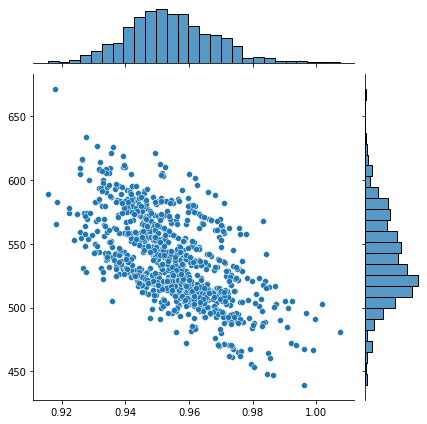

In [85]:
sns.jointplot(x=optimal_price, y=optimal_quantity)

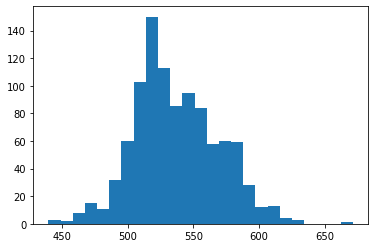

In [88]:
plt.hist(optimal_quantity, bins=25)
plt.show()

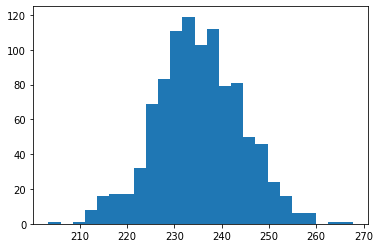

In [89]:
plt.hist(expect_profit, bins=25)
plt.show()